In [6]:
class Instr(object):
    def __init__(self, function, addr, mnemonic, op_str):
        self.function = function
        self.addr = addr
        self.mnemonic = mnemonic
        self.op_str = op_str
    def __str__(self):
        return f'{self.function}@{hex(self.addr)}: {self.mnemonic} {self.op_str}'

class Line(object):
    def __init__(self, filename, lineno, addr):
        self.filename = filename
        self.lineno = lineno
        self.addr = addr
    def __str__(self):
        return f'{self.filename}:{self.lineno}({hex(self.addr)})'

In [8]:
from elftools.elf.elffile import ELFFile
from elftools.elf.sections import SymbolTableSection

file = open("libftfp.so", "rb")
elf = ELFFile(file)
sections = list(elf.iter_sections())
text_section = [s for s in sections if s.name == ".text"][0]

In [10]:
symbol_tables = [s for s in sections if isinstance(s, SymbolTableSection)]
dynsym = [s for s in symbol_tables if s.name == ".dynsym"][0];

In [12]:
functions = [sym for _, sym in enumerate(dynsym.iter_symbols()) if sym['st_info']['type'] == "STT_FUNC" and sym.name[:4] == "fix_"]

In [14]:
def get_function_code(function):
    begin_idx = function['st_value'] - text_section['sh_offset']
    end_idx = begin_idx + function['st_size']
    return text_section.data()[begin_idx:end_idx]

In [16]:
general_purpose_regs = ["W" + str(i) for i in range(0, 31)] + ["X" + str(i) for i in range(0, 31)] + ["SP", "LR", "XZR"]
dit_instrs = ['ADC', 'ADCS', 'ADD', 'ADDS', 'AND', 'ANDS', 'ASR', 'ASRV', 'BFC', 'BFI', 'BFM', 'BFXIL', 'BIC', 'BICS', 'CCMN', 'CCMP', 'CFINV', 'CINC', 'CINV', 'CLS', 'CLZ', 'CMN', 'CMP', 'CNEG', 'CSEL', 'CSET', 'CSETM', 'CSINC', 'CSINV', 'CSNEG', 'EON', 'EOR', 'EXTR', 'LSL', 'LSLV', 'LSR', 'LSRV', 'MADD', 'MNEG', 'MOV', 'MOVK', 'MOVN', 'MOVZ', 'MSUB', 'MUL', 'MVN', 'NEG', 'NEGS', 'NGC', 'NGCS', 'NOP', 'ORN', 'ORR', 'RBIT', 'RET', 'REV', 'REV16', 'REV32', 'REV64', 'RMIF', 'ROR', 'RORV', 'SBC', 'SBCS', 'SBFIZ', 'SBFM', 'SBFX', 'SETF8', 'SETF16', 'SMADDL', 'SMNEGL', 'SMSUBL', 'SMULH', 'SMULL', 'SUB', 'SUBS', 'SXTB', 'SXTH', 'SXTW', 'TST', 'UBFIZ', 'UBFM', 'UBFX', 'UMADDL', 'UMNEGL', 'UMSUBL', 'UMULH', 'UMULL', 'UXTB', 'UXTH'] # these are the instructions for the general-purpose register file
dit_simd_instrs = ["ABS", "ADD", "ADDHN", "ADDHN2", "ADDP", "ADDV", "AND", "BIC", "BIF", "BIT", "BSL", "CLS", "CLZ", "CMEQ", "CMGE", "CMGT", "CMHI", "CMHS", "CMLE", "CMLT", "CMTST", "CNT", "CRC32B", "CRC32H", "CRC32W", "CRC32X", "CRC32CB", "CRC32CH", "CRC32CW", "CRC32CX", "DUP", "EOR", "EXT", "FCSEL", "INS", "MLA", "MLS", "MOV", "MOVI", "MUL", "MVN", "MVNI", "NEG", "NOT", "ORN", "ORR", "PMUL", "PMULL", "PMULL2", "RADDHN", "RADDHN2", "RBIT", "REV16", "REV32", "RSHRN", "RSHRN2", "RSUBHN", "RSUBHN2", "SABA", "SABD", "SABAL", "SABAL2", "SABDL", "SABDL2", "SADALP", "SADDL", "SADDL2", "SADDLP", "SADDLV", "SADDW", "SADDW2", "SHADD", "SHL", "SHLL", "SHLL2", "SHRN", "SHRN2", "SHSUB", "SLI", "SMAX", "SMAXP", "SMAXV", "SMIN", "SMINP", "SMINV", "SMLAL", "SMLAL2", "SMLSL", "SMLSL2", "SMOV", "SMULL", "SMULL2", "SRI", "SSHL", "SSHLL", "SSHLL2", "SSHR", "SSRA", "SSUBL", "SSUBL2", "SSUBW", "SSUBW2", "SUB", "SUBHN", "SUBHN2", "SXTL", "SXTL2", "TBL", "TBX", "TRN1", "TRN2", "UABA", "UABAL", "UABAL2", "UABD", "UABDL", "UABDL2", "UADALP", "UADDL", "UADDL2", "UADDLP", "UADDLV", "UADDW", "UADDW2", "UHADD", "UHSUB", "UMAX", "UMAXP", "UMAXV", "UMIN", "UMINP", "UMINV", "UMLAL", "UMLAL2", "UMLSL", "UMOV", "UMLSL2", "UMULL", "UMULL2", "USHL", "USHLL", "USHLL2", "USHR", "USRA", "USUBL", "USUBL2", "USUBW", "USUBW2", "UXTL", "UXTL2", "UZP1", "UZP2", "XTN", "XTN2", "ZIP1", "ZIP2"] # these are the instructions for the SIMD & FP register file

In [18]:
from capstone import *

bad_instrs = []
all_instrs = []
md = Cs(CS_ARCH_ARM64, CS_MODE_ARM)

for function in functions:
    code = get_function_code(function)
    print(function.name, len(code))
    
    instrs = [i for i in md.disasm_lite(code, function['st_value'])]
    
    if(len(instrs) != len(code) / 4): 
        print("invalid disassembly for " + function.name)
        continue
    
    for (addr, size, mnemonic, op_str) in instrs:
        if(op_str == '' or op_str.split(",")[0].upper() in general_purpose_regs):
            if(mnemonic.upper() not in dit_instrs):
                bad_instrs += [Instr(function.name, addr, mnemonic, op_str)]
        elif(mnemonic.upper() not in dit_simd_instrs):
            bad_instrs += [Instr(function.name, addr, mnemonic, op_str)]
        all_instrs += [Instr(function.name, addr, mnemonic, op_str)]

fix_cos 31668
fix_ceil64 68
fix_floor 60
fix_ne 64
fix_cmp 188
fix_sprint 13432
fix_div 4244
fix_convert_to_int64 88
fix_gt 208
fix_convert_from_int64 52
fix_sqrt 85088
fix_le 208
fix_is_neg 8
fix_eq 56
fix_convert_to_double_internal 336
fix_is_inf_neg 16
fix_floor64 60
fix_print 100
fix_sin 31700
fix_round_up_int64 68
fix_mul 420
fix_ln 6068
fix_neg 72
fix_ceil 92
fix_abs 88
fix_is_inf_pos 16
fix_println 36
fix_lt 192
fix_convert_from_double_internal 424
fix_tan 36044
fix_pow 18432
fix_eq_nan 52
fix_exp 11024
fix_ge 204
fix_sub 200
fix_log10 6100
fix_is_nan 16
fix_log2 6156
fix_add 132


In [20]:
set([i.mnemonic for i in bad_instrs])

{'adrp', 'bl', 'cbnz', 'ldp', 'ldr', 'ldrb', 'stp', 'str', 'strb'}

In [22]:
from bisect import bisect_left

dwarf = elf.get_dwarf_info()
def get_lines_from_cu(cu):
    res = []
    lineprogram = dwarf.line_program_for_CU(cu)
    for entry in lineprogram.get_entries():
        state = entry.state
        if state is not None:
            res += [Line(lineprogram['file_entry'][state.file-1].name, state.line, state.address)]
    return res

def get_lines_from_dwarf(dwarf):
    res = []
    for cu in dwarf.iter_CUs():
        res += get_lines_from_cu(cu)
    return sorted(res, key=lambda l: l.addr)

def find_line(lines, addr):
    exact_matches = [l for l in filter(lambda line: line.addr == addr, lines)]
    if(len(exact_matches) != 0):
        return exact_matches
    addrs = [l.addr for l in lines]
    return [lines[bisect_left(addrs, addr) - 1]]

lines = get_lines_from_dwarf(dwarf)

In [225]:
all_mne = [m for m in set([i.mnemonic for i in all_instrs]) if len([i for i in all_instrs if i.mnemonic == m]) > 5]

In [226]:
from collections import defaultdict
def mne_counts(func_name):
    res = defaultdict(lambda: 0)
    for i in all_instrs:
        if i.function == func_name:
            res[i.mnemonic]+=1
    return res


In [227]:
func_ccnt = [(e[0].strip(), e[1]) for e in [["fix_neg        ", 0.998375],
["fix_abs        ", 0.998625],
["fix_is_neg     ", 0.998650],
["fix_is_nan     ", 0.998600],
["fix_is_inf_pos ", 0.998650],
["fix_is_inf_neg ", 0.998475],
["fix_eq         ", 0.998750],
["fix_eq_nan     ", 0.998475],
["fix_cmp        ", 0.998200],

["fix_add        ", 0.998500],
["fix_sub        ", 0.998550],
["fix_mul        ", 0.998100],
["fix_div        ", 0.991575],

["fix_floor      ", 0.998625],
["fix_ceil       ", 0.998700],

["fix_exp        ", 0.987700],
["fix_ln         ", 0.986825],
["fix_log2       ", 0.993500],
["fix_log10      ", 0.990525],

["fix_pow        ", 0.965925],
["fix_sqrt       ", 0.056900],

["fix_sin        ", 0.132450],
["fix_cos        ", 0.137075],
["fix_tan        ", 0.018025],

["fix_sprint      ", 0.972675]]]

In [228]:
import math
Y = [-math.log2(e[1]) for e in func_ccnt]
Y

[0.0023462863158012584,
 0.001985070730316673,
 0.001948954145445602,
 0.0020211882193567395,
 0.001948954145445602,
 0.002201789228679557,
 0.0018044968467478767,
 0.002201789228679557,
 0.0025991910479572374,
 0.0021656672181143925,
 0.0020934259101255963,
 0.0027437279454271078,
 0.012206196829701001,
 0.001985070730316673,
 0.0018767236880300182,
 0.017855184894581086,
 0.01913382987847412,
 0.009408127412416836,
 0.013734706929729756,
 0.050016920659313076,
 4.135427537242868,
 2.916480251179827,
 2.8669626212526502,
 5.793856930308627,
 0.03997025721123338]

In [229]:
def get_x(func_name):
    mne = mne_counts(func_name)
    return [mne[m] for m in all_mne] + [sum([mne[m] for m in all_mne])]
X = [get_x(e[0]) for e in func_ccnt]

In [230]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(positive=True).fit(X, Y)

In [231]:
reg.score(X, Y)

0.9177114563279911

In [232]:
feats = all_mne + ["length"]
weights = [(feats[i], reg.coef_[i]) for i in range(len(reg.coef_))]
weights

[('lsl', 0.0),
 ('orr', 0.0),
 ('cinc', 0.0),
 ('ands', 0.0),
 ('csetm', 0.0),
 ('bfi', 0.0),
 ('and', 0.0),
 ('csneg', 0.0),
 ('add', 0.0),
 ('sbfx', 0.0),
 ('ret', 0.0),
 ('ubfiz', 0.0),
 ('neg', 0.0),
 ('asr', 0.04956155891970594),
 ('sub', 0.0),
 ('tst', 0.0),
 ('bics', 0.0),
 ('ldp', 0.0),
 ('mov', 0.003294337952791778),
 ('mul', 0.0),
 ('stp', 0.0),
 ('csinc', 0.0),
 ('csel', 0.0),
 ('movn', 0.0),
 ('ldr', 0.0),
 ('movz', 0.0),
 ('strb', 0.0),
 ('bfxil', 0.0),
 ('str', 0.0),
 ('movk', 0.0),
 ('cset', 0.0),
 ('ccmp', 0.0),
 ('cmp', 0.0),
 ('madd', 0.0012908555160057336),
 ('adds', 0.0),
 ('lsr', 0.0),
 ('ubfx', 0.0),
 ('eor', 0.0043347911887794315),
 ('umull', 0.0),
 ('mvn', 0.0),
 ('length', 0.0)]

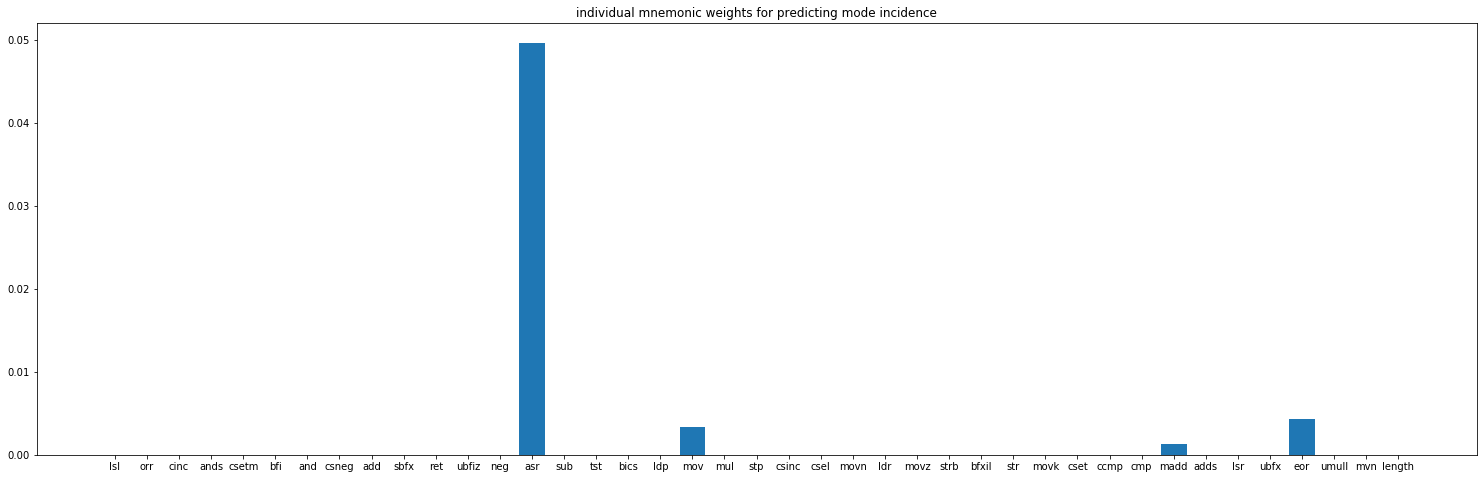

In [233]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 6))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("individual mnemonic weights for predicting mode incidence")
ax.bar([w[0] for w in weights], [w[1] for w in weights])
plt.show()

In [234]:
set([i.function for i in all_instrs if i.mnemonic == "sxtw"])

{'fix_div', 'fix_tan'}